# Bank Marketing Campaign Success Prediction
Using Machine Learning to Predict Term Deposit Subscription

- Problem type: Binary classification (target: y)
- Dataset: Kaggle Bank Marketing (bank-additional-full.csv)
- Goal: Predict if a client will subscribe to a term deposit (yes/no)

What you'll get in this notebook:
- Robust preprocessing (scaling numeric, one-hot encoding categorical)
- Class imbalance handling with class weights (and optional SMOTE)
- Primary model: Random Forest (recommended)
- Optional experiments: KNN and SVM
- Evaluation: Accuracy, Precision, Recall, F1, ROC-AUC, Confusion Matrix, PR curves
- Feature importance (for Random Forest)
- Optional threshold tuning to boost precision


In [10]:
# Imports and setup
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay,
    precision_recall_curve
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Optional: SMOTE oversampling if imblearn is installed
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
except Exception:
    IMBLEARN_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("✅ Libraries imported. imbalanced-learn available:", IMBLEARN_AVAILABLE)


✅ Libraries imported. imbalanced-learn available: True


In [11]:
# Load data
CSV_PATH = r"d:\bank-marketing-campaign\bank-additional-full.csv"

df = pd.read_csv(CSV_PATH, sep=';')
print("Shape:", df.shape)
print(df.head(3))

# Target mapping: 'y' -> 1 for 'yes', 0 for 'no'
df['y'] = df['y'].map({'yes': 1, 'no': 0})
print("\nClass distribution (y):\n", df['y'].value_counts(normalize=True).rename({0:'no',1:'yes'}))


Shape: (41188, 21)
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  

[3 rows x 21 columns]

Class distribution (y):
 y
no     0.887346
yes    0.112654
Name: proportion

In [12]:
# Preprocessing: feature lists and transformers

target_col = 'y'
# Add engineered feature for age > 50 (clients above 50 are less likely to subscribe)
df['age_above_50'] = (df['age'] > 50).astype(int)

X = df.drop(columns=[target_col])
y = df[target_col]

# Auto-detect types
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"Numeric: {len(numeric_features)} | Categorical: {len(categorical_features)}")

# Robust OneHotEncoder creation for sklearn versions
try:
    ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
except TypeError:
    # For older sklearn (<1.2) where sparse_output isn't available
    ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train/Test sizes:", X_train.shape, X_test.shape)
print("Train class distribution:\n", y_train.value_counts(normalize=True).rename({0:'no',1:'yes'}))

Numeric: 11 | Categorical: 10
Train/Test sizes: (32950, 21) (8238, 21)
Train class distribution:
 y
no     0.887344
yes    0.112656
Name: proportion, dtype: float64


In [13]:
# Configuration: models and imbalance strategy

# Primary model to run by default
RUN_MODELS = ['RandomForest']  # options: 'RandomForest', 'KNN', 'SVM'

# Optional oversampling (requires imblearn). Default False because we use class weights.
USE_SMOTE = False and IMBLEARN_AVAILABLE
SMOTE_K_NEIGHBORS = 5

print("Models to run:", RUN_MODELS)
print("USE_SMOTE:", USE_SMOTE, "(imblearn available:", IMBLEARN_AVAILABLE, ")")


Models to run: ['RandomForest']
USE_SMOTE: False (imblearn available: True )


In [14]:
# Helper: build pipelines per model, with class weights and optional SMOTE

def build_pipeline(model_name: str):
    if model_name == 'RandomForest':
        clf = RandomForestClassifier(
            n_estimators=300,
            class_weight='balanced',  # addresses class imbalance
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    elif model_name == 'KNN':
        # KNN ignores class_weight; relies on oversampling if enabled
        clf = KNeighborsClassifier(n_neighbors=25)
    elif model_name == 'SVM':
        # SVM with class weight; can be slow on full data
        clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, class_weight='balanced', random_state=RANDOM_STATE)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    if USE_SMOTE and IMBLEARN_AVAILABLE:
        # SMOTE happens after preprocessing, before classifier
        return ImbPipeline(steps=[
            ('preprocess', preprocessor),
            ('smote', SMOTE(random_state=RANDOM_STATE, k_neighbors=SMOTE_K_NEIGHBORS)),
            ('clf', clf)
        ])
    else:
        return Pipeline(steps=[
            ('preprocess', preprocessor),
            ('clf', clf)
        ])

print("✅ Pipeline builder ready.")


✅ Pipeline builder ready.



=== Training: RandomForest ===
Scores -> Acc: 0.9158 | Prec: 0.6950 | Rec: 0.4494 | F1: 0.5458 | ROC-AUC: 0.9504

Classification Report:
               precision    recall  f1-score   support

           0     0.9331    0.9750    0.9536      7310
           1     0.6950    0.4494    0.5458       928

    accuracy                         0.9158      8238
   macro avg     0.8140    0.7122    0.7497      8238
weighted avg     0.9063    0.9158    0.9076      8238



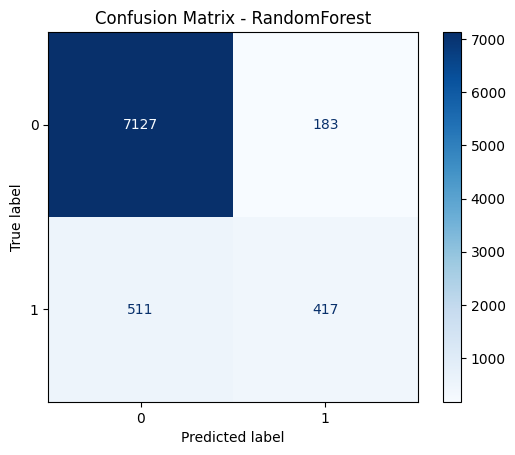

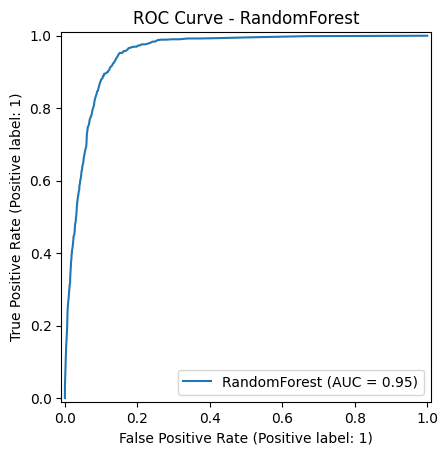

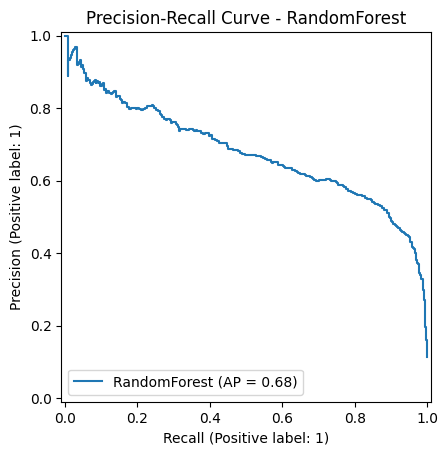


Model comparison:


,model,accuracy,precision,recall,f1,roc_auc
0,RandomForest,0.915756,0.695,0.449353,0.545812,0.950392


In [15]:
# Train and evaluate selected models

results = []
model_objects = {}

for name in RUN_MODELS:
    print("\n=== Training:", name, "===")
    pipe = build_pipeline(name)
    pipe.fit(X_train, y_train)

    # Predictions and scores
    y_pred = pipe.predict(X_test)
    # Probability for ROC-AUC and PR; fall back to decision_function if needed
    if hasattr(pipe, 'predict_proba'):
        y_proba = pipe.predict_proba(X_test)[:, 1]
    else:
        # e.g., LinearSVC; but for SVC(probability=True) we have predict_proba
        try:
            y_proba = pipe.decision_function(X_test)
        except Exception:
            y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    results.append({'model': name, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc})
    model_objects[name] = {'pipeline': pipe, 'proba': y_proba, 'pred': y_pred}

    print(f"Scores -> Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC Curve
    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba, name=name)
        plt.title(f"ROC Curve - {name}")
        plt.show()

        # Precision-Recall Curve
        PrecisionRecallDisplay.from_predictions(y_test, y_proba, name=name)
        plt.title(f"Precision-Recall Curve - {name}")
        plt.show()

# Summary table
results_df = pd.DataFrame(results).sort_values(by=['f1','roc_auc'], ascending=False)
print("\nModel comparison:")
display(results_df)


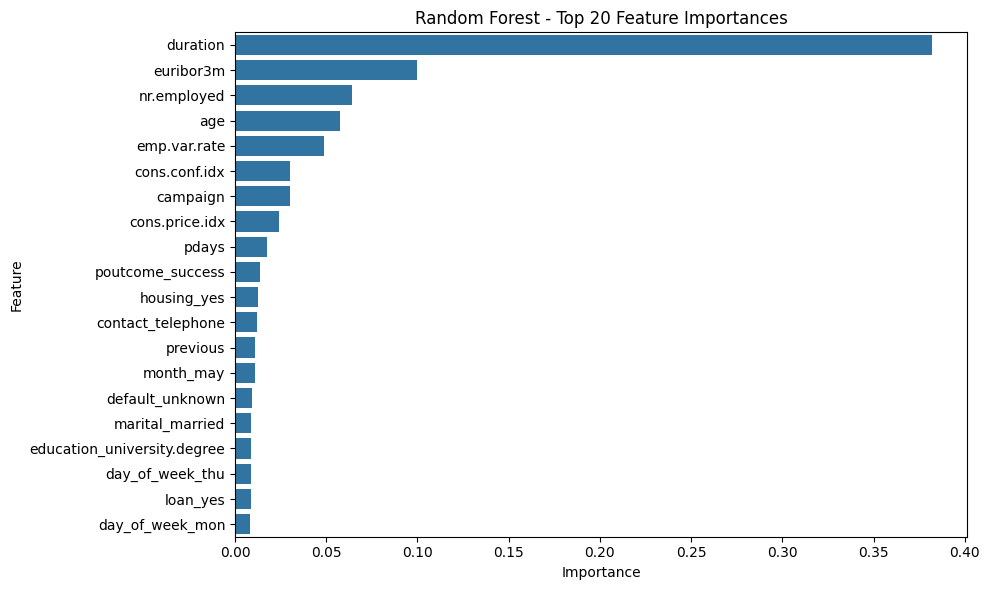

In [16]:
# Random Forest feature importance (top 20)

if 'RandomForest' in model_objects:
    pipe_rf = model_objects['RandomForest']['pipeline']
    clf_rf = pipe_rf.named_steps['clf']
    # Get feature names after preprocessing
    num_names = numeric_features
    try:
        cat_names = pipe_rf.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
    except Exception:
        # Fallback for older sklearn
        cat_names = []
        try:
            cat_names = pipe_rf.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features)
        except Exception:
            pass
    feature_names = num_names + list(cat_names)

    importances = clf_rf.feature_importances_
    top_idx = np.argsort(importances)[-20:][::-1]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[top_idx], y=np.array(feature_names)[top_idx])
    plt.title('Random Forest - Top 20 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Random Forest not in RUN_MODELS; skipping feature importance.")


In [17]:
# Cross-validation to check if model is trained correctly (Random Forest)

from sklearn.model_selection import cross_val_score, StratifiedKFold

if 'RandomForest' in model_objects:
    pipe_rf = model_objects['RandomForest']['pipeline']
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(pipe_rf, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    print(f"Cross-validation F1 scores: {scores}")
    print(f"Mean F1: {scores.mean():.4f} ± {scores.std():.4f}")

    # Also check accuracy
    acc_scores = cross_val_score(pipe_rf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"Cross-validation Accuracy scores: {acc_scores}")
    print(f"Mean Accuracy: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
else:
    print("Random Forest not trained; skipping CV.")

Cross-validation F1 scores: [0.48976109 0.50618302 0.48671096 0.4954583  0.49143836]
Mean F1: 0.4939 ± 0.0068
Cross-validation Accuracy scores: [0.90925645 0.9091047  0.90622155 0.90728376 0.90986343]
Mean Accuracy: 0.9083 ± 0.0014


Selected threshold 0.420 achieving precision>=0.65 with recall 0.587
Tuned -> Acc: 0.9179 | Prec: 0.6504 | Rec: 0.5873 | F1: 0.6172 @ thr=0.420


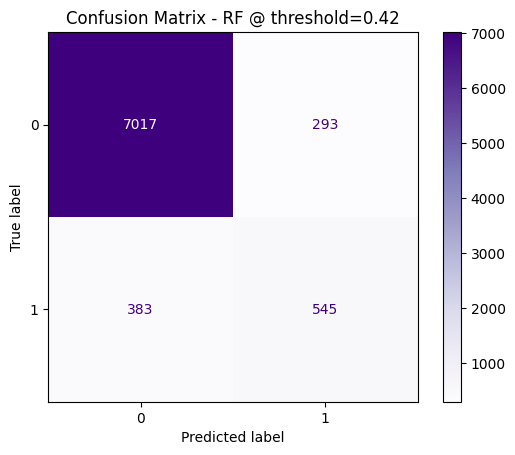

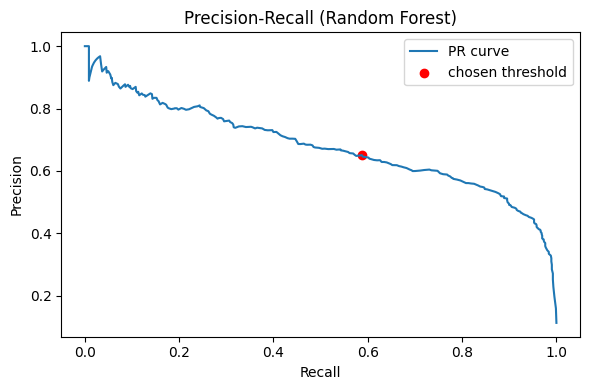

In [19]:
# Threshold tuning for precision (Random Forest)

TARGET_MIN_PRECISION = 0.65  # adjust as needed

if 'RandomForest' in model_objects and model_objects['RandomForest']['proba'] is not None:
    y_proba = model_objects['RandomForest']['proba']
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

    # Find threshold meeting target precision with best recall
    best_idx = None
    best_recall = -1
    best_thresh = 0.5
    for p, r, t in zip(precisions, recalls, np.append(thresholds, 1.0)):
        if p >= TARGET_MIN_PRECISION and r > best_recall:
            best_recall = r
            best_idx = (p, r, t)
            best_thresh = t

    if best_idx is None:
        # Fallback: maximize F0.5
        fbeta = (1 + 0.5**2) * (precisions * recalls) / (0.5**2 * precisions + recalls + 1e-12)
        i = int(np.nanargmax(fbeta))
        best_thresh = thresholds[i-1] if i > 0 else 0.5
        print(f"No threshold reached precision>={TARGET_MIN_PRECISION:.2f}. Using F0.5-optimal threshold: {best_thresh:.3f}")
    else:
        print(f"Selected threshold {best_thresh:.3f} achieving precision>={TARGET_MIN_PRECISION:.2f} with recall {best_recall:.3f}")

    y_pred_tuned = (y_proba >= best_thresh).astype(int)
    acc = accuracy_score(y_test, y_pred_tuned)
    prec = precision_score(y_test, y_pred_tuned, zero_division=0)
    rec = recall_score(y_test, y_pred_tuned, zero_division=0)
    f1 = f1_score(y_test, y_pred_tuned, zero_division=0)
    print(f"Tuned -> Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} @ thr={best_thresh:.3f}")

    cm = confusion_matrix(y_test, y_pred_tuned)
    ConfusionMatrixDisplay(cm).plot(cmap='Purples')
    plt.title(f"Confusion Matrix - RF @ threshold={best_thresh:.2f}")
    plt.show()

    # Visualize PR with chosen point
    plt.figure(figsize=(6,4))
    plt.plot(recalls, precisions, label='PR curve')
    # Find closest point to chosen threshold for visualization
    try:
        idx = np.argmin(np.abs(thresholds - best_thresh))
        plt.scatter(recalls[idx], precisions[idx], color='red', label='chosen threshold')
    except Exception:
        pass
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (Random Forest)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Random Forest probabilities not available; skipping threshold tuning.")


Prediction stats by age group:
              mean_proba  accuracy
age_above_50                      
0               0.099635  0.921451
1               0.145616  0.888577


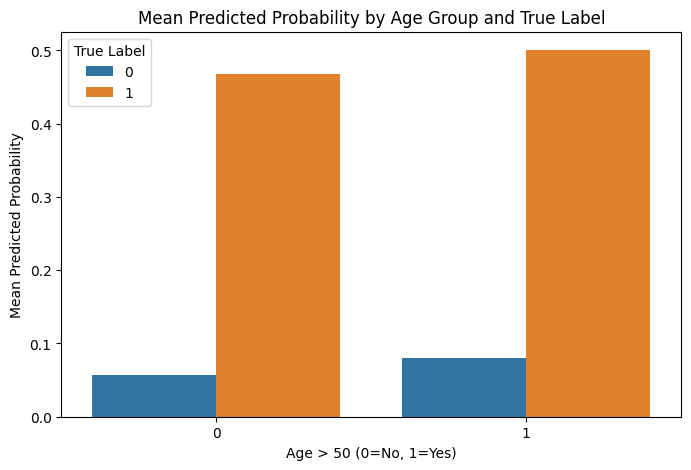

In [18]:
# Analyze predictions by age groups to check if age > 50 condition is learned

if 'RandomForest' in model_objects:
    y_pred = model_objects['RandomForest']['pred']
    y_proba = model_objects['RandomForest']['proba']

    # Add predictions to test set for analysis
    test_analysis = X_test.copy()
    test_analysis['y_true'] = y_test
    test_analysis['y_pred'] = y_pred
    if y_proba is not None:
        test_analysis['y_proba'] = y_proba

    # Group by age_above_50
    test_analysis['age_above_50'] = (test_analysis['age'] > 50).astype(int)

    # Mean predicted probability and accuracy by group
    group_stats = test_analysis.groupby('age_above_50').agg({
        'y_proba': 'mean',
        'y_pred': lambda x: (x == test_analysis.loc[x.index, 'y_true']).mean()  # accuracy
    }).rename(columns={'y_pred': 'accuracy', 'y_proba': 'mean_proba'})

    print("Prediction stats by age group:")
    print(group_stats)

    # Visualize
    plt.figure(figsize=(8,5))
    sns.barplot(data=test_analysis, x='age_above_50', y='y_proba', hue='y_true', ci=None)
    plt.title('Mean Predicted Probability by Age Group and True Label')
    plt.xlabel('Age > 50 (0=No, 1=Yes)')
    plt.ylabel('Mean Predicted Probability')
    plt.legend(title='True Label')
    plt.show()
else:
    print("Random Forest not available; skipping age analysis.")

In [20]:
# Optional: persist model and threshold
import os
from pathlib import Path

try:
    import joblib
    JOBLIB_AVAILABLE = True
except Exception:
    JOBLIB_AVAILABLE = False

if 'RandomForest' in model_objects and JOBLIB_AVAILABLE:
    models_dir = Path('d:/bank-marketing-campaign/models')
    models_dir.mkdir(parents=True, exist_ok=True)
    pipe_rf = model_objects['RandomForest']['pipeline']
    joblib.dump(pipe_rf, models_dir / 'rf_pipeline.joblib')
    print("✅ Saved:", models_dir / 'rf_pipeline.joblib')
else:
    print("joblib not available or RandomForest not trained; skipping save.")


✅ Saved: d:\bank-marketing-campaign\models\rf_pipeline.joblib
